# Final Report #

## Introduction 
### Background Information: 

Online video games like Minecraft can support many players at the same time, but research servers work differently from commercial ones. A research group in Computer Science at the University of British Columbia, led by Frank Wood is collecting data on how people play video games. They are doing this through a Minecraft server that collects real player data for scientific study. Their Minecraft server records player actions like exploring, building, and interacting in the world. 

A broad question that this research group is interested in focuses on finding player types that generate large amounts of data. One way to measure data contribution is through total hours played, since longer playtime results in more recorded in-game actions. In this project, we use the players dataset to test whether a player’s age can predict their total played hours. This is treated as a predictive question, where age is the input feature and played hours is the target outcome. By applying data science methods such as data cleaning, visualization, and building a simple predictive model, we can evaluate if age has a meaningful relationship with played hours. If age is a strong predictor, the UBC Computer Science team could focus recruitment efforts on the age groups most likely to generate high playtime and contribute more data. 

### Specific Question: 

Can a **player's age** be used to predict the **total amount of hours** a player spends on the MineCraft server?

### Dataset Used: 
`players.csv` Dataset:

### Data Description
- 196 observations
- 7 variables
  
### Variables 

|#| Variable Name | Type of Variable | Variable Meaning | Data Type |
|:--------:|:--------|:--------|:--------|:--------:|
|1| `experience`  | Qualitative (Categorical)  | player’s experience level | chr |
|2| `subscribe`  | Qualitative (Categorical)  | whether the player is subscribed to a game-related newsletter(True/False)  | lgl |
|3| `hashedEmail`  | Qualitative  | player’s email  | chr |
|4| `played hours`  | Quantitative  | total number of hours played in Minecraft  | dbl |
|5| `name`  | Qualitative  | player’s name  | chr |
|6|`gender` | Qualitative (Categorical)  | player’s gender  | chr |
|7| `Age`  | Quantitative  | player’s age (years)  | dbl |

### Summary Statistics
  
|#| Variable Name | Min | Mean | Median | Max |
|:--------:|:--------|:--------|:--------|:--------:|:--------:|
|1| `played_hours`  | 0.00 | 5.845 | 0.10 | 223.10|
|2|`Age`| 9.00| 21.14| 19.00 | 58.00|

#### Issues:
- few NA values are present
- `Age` should be an integer instead of double
-  Some `played_hours` values are 0.0 which could indicate missing data.


## Method

### Description
We first wrangle the players dataset by omit NAs and 0s from the played_hours column, as they are not relevant to our prediction. Then, we select only the age and played-hours columns. 

We split the dataset into a training and testing dataset at a 75:25 ratio. Then, we train a K-NN model using the training dataset, while tuning the K-value. Selecting the K-value that returns the minimum rmse value, we now have our model. 

With the model, we apply it to our testing set to see how well our model can generalize to different data samples.

### Load Dataset

In [3]:
#load in packages
library(tidymodels)
library(tidyverse)

#read in datasets
players <- read_csv("players.csv")

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ rsample      1.2.1
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.1     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.1.2
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::

### Wrangles and Clean

In [4]:
players_wrangled <- players |>
    select(played_hours, Age) |>
    filter(played_hours != 0) |>
    na.omit()

head(players_wrangled, 6)

played_hours,Age
<dbl>,<dbl>
30.3,9
3.8,17
0.7,21
0.1,21
0.1,47
1.6,23


#### Figure 1: Wrangled and cleaned dataset

### Summary

In [5]:
summary(players_wrangled)
nrow(players_wrangled)

  played_hours         Age      
 Min.   :  0.10   Min.   : 9.0  
 1st Qu.:  0.10   1st Qu.:17.0  
 Median :  0.50   Median :20.0  
 Mean   : 10.51   Mean   :21.3  
 3rd Qu.:  1.80   3rd Qu.:23.0  
 Max.   :223.10   Max.   :58.0  

[1] 109

#### Figure 2: Summary of the wrangled dataset

### Visualization

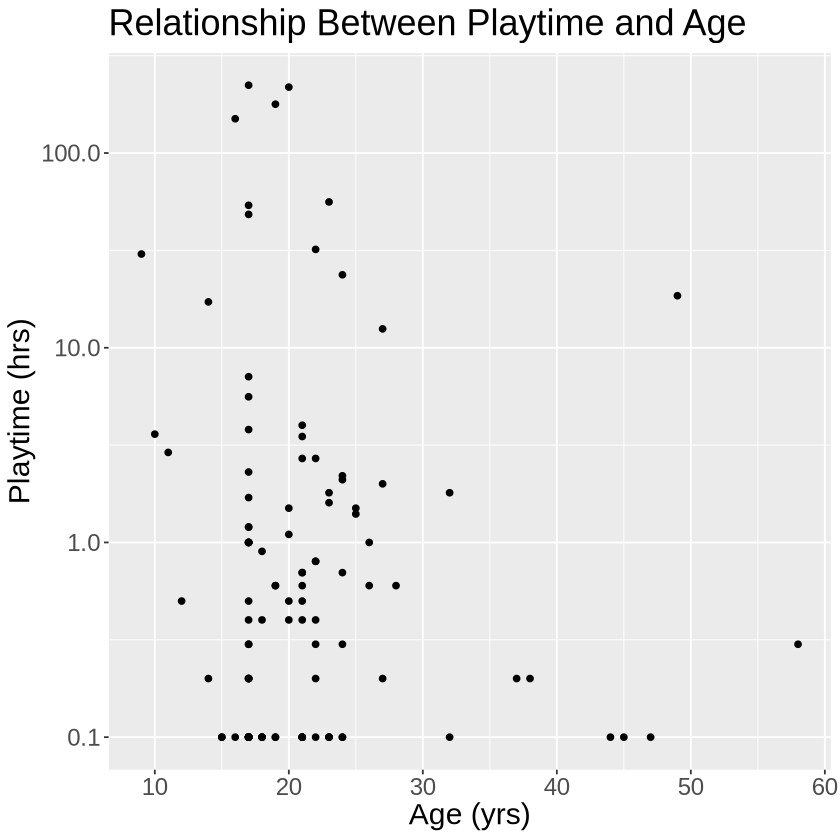

In [6]:
players_select_plot <- ggplot(players_wrangled, aes(y = played_hours, x = Age)) + 
    geom_point() +
    scale_y_log10() +
    labs(y = "Playtime (hrs)", x = "Age (yrs)", title = "Relationship Between Playtime and Age") +
    theme(text = element_text(size = 18))

players_select_plot

#### Figure 3: A visualization of the relationship between played hours and age.

### K-NN Regression

In [7]:
set.seed(11)

players_split <- initial_split(players_wrangled, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

players_recipe <- recipe(played_hours ~ Age, data = players_train) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)

players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)

gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

players_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics()

players_min <- players_results |>
    filter(.metric == "rmse") |>
    filter(mean == min(mean))

players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
32,rmse,standard,29.69629,5,10.22014,Preprocessor1_Model32


#### Figure 4: The smallest RMSE occurs when K = 32

In [8]:
k_min <- players_min |>
         pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

players_best_fit <- workflow() |>
         add_recipe(players_recipe) |>
         add_model(players_best_spec) |>
         fit(data = players_train)

players_summary <- players_best_fit |>
    predict(players_test) |>
    bind_cols(players_test) |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter(.metric == "rmse")

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,42.60281


#### Figure 5: RMSPE

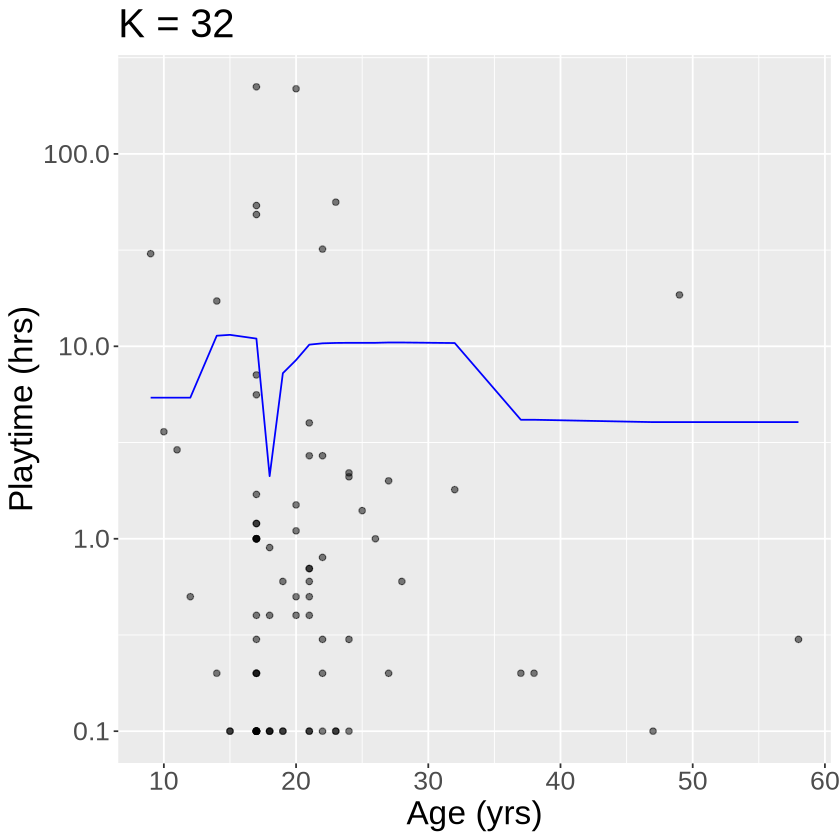

In [9]:
players_preds <- predict(players_best_fit, players_train) |>
    bind_cols(players_train)

players_plot <- ggplot(players_preds, aes(x = Age, y = played_hours)) +
    geom_point(alpha = 0.5) +
    geom_line(aes(y = .pred), color = "blue") +
    scale_y_log10() +
    labs(y = "Playtime (hrs)", x = "Age (yrs)", title = "K = 32") +
    theme(text = element_text(size = 20))

players_plot

#### Figure 6: Predicted values of played hours (blue line) for the final K-NN regression model

## Linear Regression

In [11]:
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

lm_recipe <- recipe(played_hours ~ Age, data = players_train)

lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = players_train)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          Age  
    14.9973      -0.2689  


In [13]:
lm_test_results <- lm_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = Age, estimate = .pred)

lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,16.53536
rsq,standard,1.00000
mae,standard,13.82372


.pred,Age
<dbl>,<dbl>
13.177653507,9
0.003978723,58


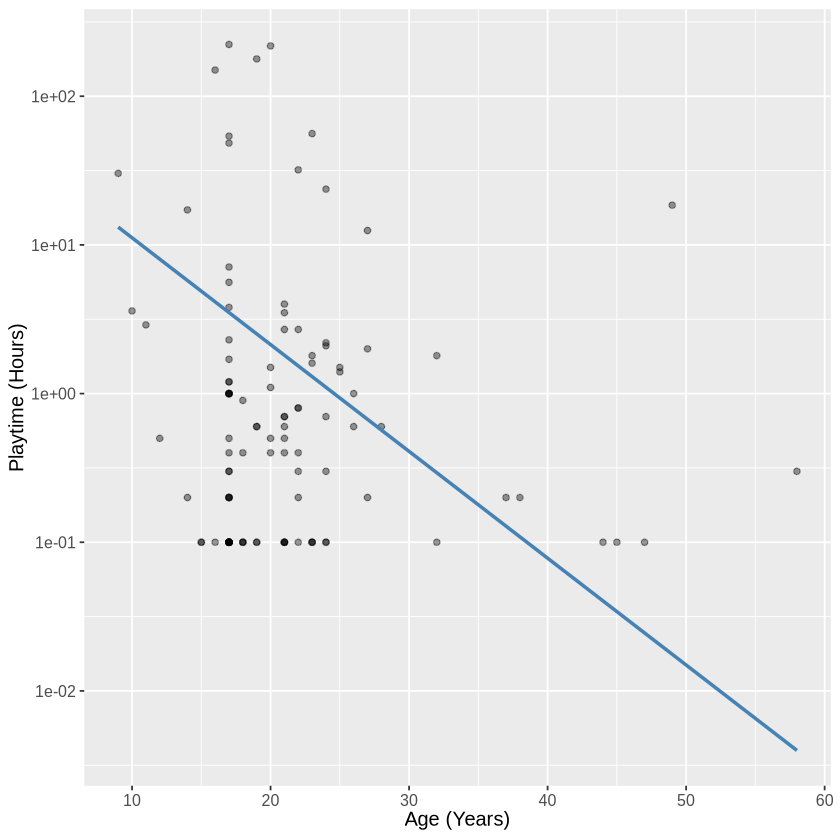

In [29]:
played_hours_prediction_grid <- tibble(
    Age = c(
        players_wrangled |> select(Age) |> min(),
        players_wrangled |> select(Age) |> max()
    )
)

player_preds <- lm_fit |>
  predict(played_hours_prediction_grid) |>
  bind_cols(played_hours_prediction_grid) |>
  mutate(.pred = .pred + 0.6)

player_preds

lm_plot_final <- ggplot(players_wrangled, aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(data = player_preds,
            mapping = aes(x = Age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
  xlab("Age (Years)") +
  ylab("Playtime (Hours)") +
  scale_y_log10() +
  theme(text = element_text(size = 12))

lm_plot_final

In [30]:
coeffs <- lm_fit |>
             extract_fit_parsnip() |>
             tidy()

coeffs

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),14.9973081,11.4333863,1.3117118,0.1934166
Age,-0.2688505,0.5150693,-0.5219696,0.6031520


# Discussion

### Summary of Findings

Our analysis aimed to predict the number of hours a player spends on the Minecraft server based on their age using k-Nearest Neighbors (k-NN) regression. 

After performing cross-validation to tune the hyperparameter $k$, we identified the optimal number of neighbors to be $k=30$ However, the resulting model demonstrated very poor predictive power. The Root Mean Square Error (RMSE) on the test set was approximately 19.63 5, and the $R^2$ metric was extremely low at roughly 0.0156. Visually, the model’s prediction line in Figure 7 remains relatively flat across most ages, failing to capture any distinct trend between age and playtime. These metrics indicate that age, in isolation, is not a strong predictor of playtime in this dataset.

### Expectations vs. Reality

We initially expected to see a correlation between age and playtime—perhaps hypothesizing that younger players might have more free time and thus higher played hours. However, our findings contradict this expectation. The dataset is heavily skewed towards players with little to no playtime (Median = 0.10 hours), with a few significant outliers in the 15–25 age range driving the mean up to 5.85 hours. The large number of near-zero values suggests that most users in the dataset, regardless of age, did not engage deeply with the server. Consequently, the k-NN model struggled to find a signal amidst the noise of "inactive" players.

### Impact of Findings

Despite the negative result, this analysis provides valuable insight for server management or community targeting. The lack of a strong relationship suggests that marketing efforts or server capacity planning should not be based on the age demographics of the user base. For example, knowing that a new influx of users is 18 years old versus 40 years old gives the server administrators no reliable information on how much server load (playtime) to expect. The variance in playtime is driven by factors other than age.

### Future Questions and Improvements

These findings lead to several important questions for future research:
- Feature Engineering and Selection: Since age is a poor predictor, we should investigate if other variables in the dataset, such as experience (e.g., "Veteran" vs. "Amateur") or gender, have a stronger correlation with playtime. A future analysis could use a multivariate k-NN regression including these categorical variables.
- Data Volume: With only 196 observations, the dataset is relatively small and sensitive to outliers. Collecting more data might reveal a subtle trend that is currently obscured by the high variance.